In [1]:
### modules
import os
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

from glob import glob

In [75]:
read_image_from_path = lambda ipath: plt.imread(ipath) if os.path.exists(ipath) else FileNotFoundError(f"Image not found: {ipath}")
join_paths = lambda *args: os.path.join(*args)
listdir = lambda d: os.listdir(d) if os.path.exists(d) else []
l_leng = lambda l: len(l) if isinstance(l, (list, tuple, str, dict, set)) else str(l)
remove_ext = lambda f: os.path.splitext(f)[0] if isinstance(f, str) else f

def show_image(image, read_image=True):
    if read_image:
        image = read_image_from_path(image)

    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')

def list_files(directory, extension='.png', sort_files=True):
    files = glob(join_paths(directory, f'*{extension}'))
    if sort_files:
        files.sort()
    return files

In [3]:
def get_chunk_img_structure(split = 'train', root_dir="SciTSR"):
    c,i,s = join_paths(root_dir, split, 'chunk'), join_paths(root_dir, split, 'img'), join_paths(root_dir, split, 'structure')
    chunks = list_files(c, '.chunk')
    images = list_files(i, '.png')
    structures = list_files(s, '.json')
    return chunks, images, structures

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

In [4]:
tr_chunks, tr_images, tr_structures = get_chunk_img_structure('train')
ts_chunks, ts_images, ts_structures = get_chunk_img_structure('test')

In [5]:
print(l_leng(tr_chunks), l_leng(tr_images), l_leng(tr_structures))
# print()
print(l_leng(ts_chunks), l_leng(ts_images), l_leng(ts_structures))

12000 12000 12000
3000 3000 3000


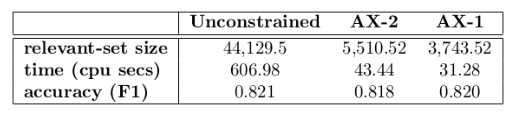

In [76]:
show_image(tr_images[1110])

In [185]:
import cv2
import torch
from PyPDF2 import PdfReader
from torch.utils.data import Dataset, DataLoader


def get_val_from_json(data, root_key_name, val_name):
    val = [c.get(val_name, []) for c in data[root_key_name]]
    return val

def upate_val_in_json(data, root_key_name, val_name, new_vals):
    for ind, row in enumerate(data[root_key_name]):
        if val_name in row:
            row[val_name] = new_vals[ind]
    return data

def kv_mapper(keys, values):
    assert len(keys) == len(values), "Keys and values must have the same length"
    n = len(keys)
    data = {keys[i]:values[i] for i in range(n)}
    return data

def replicate_chunks(pos, mapper, augmented_ids):
    data = {'chunks': []} 
    for i, p in enumerate(pos):
        data['chunks'].append({
            'pos'  : p,
            'text' : mapper[augmented_ids[i]],
        })
    return data 

def get_table_bounds_from_pdf_positions(positions, pad_px=0.0):
    """
    positions: list of [x0, x1, y0, y1] in PDF coords (bottom-left origin).
    Returns crop box of the table in PDF coords as [crop_x0, crop_y0, crop_x1, crop_y1].
    pad_px: optionally expand the crop box by a few pixels to absorb tiny mismatches.
    """
    x0 = min(p[0] for p in positions)
    x1 = max(p[1] for p in positions)
    y0 = min(p[2] for p in positions)
    y1 = max(p[3] for p in positions)

    return [x0 - pad_px, y0 - pad_px, x1 + pad_px // 2, y1 + pad_px]

def normalize_bbox_pdfcrop_to_image(bbox, crop_box, img_w, img_h, clip=True):
    """
    bbox:      [x0, x1, y0, y1] in PDF coords (bottom-left origin)
    crop_box:  [crop_x0, crop_y0, crop_x1, crop_y1] in PDF coords
    img_w,h:   rendered crop image size (pixels), top-left origin

    Returns: [x0_img, x1_img, y0_img, y1_img] in image coords (top-left origin),
             preserving the unusual order x0,x1,y0,y1.
    """
    x0, x1, y0, y1 = bbox
    cx0, cy0, cx1, cy1 = crop_box

    crop_w = max(cx1 - cx0, 1e-6)
    crop_h = max(cy1 - cy0, 1e-6)
    sx = img_w / crop_w
    sy = img_h / crop_h

    # 1) shift into crop-local PDF coords (still bottom-left origin)
    x0_loc = x0 - cx0
    x1_loc = x1 - cx0
    y0_loc = y0 - cy0  # distance from crop bottom
    y1_loc = y1 - cy0

    # 2) scale to image size
    x0_img = x0_loc * sx
    x1_img = x1_loc * sx
    # 3) flip Y to top-left origin:
    #    top = img_h - (top_from_bottom), bottom = img_h - (bottom_from_bottom)
    y_top_img    = img_h - (y1_loc * sy)
    y_bottom_img = img_h - (y0_loc * sy)

    # ensure x0<=x1, y0<=y1 in image space
    x0_img, x1_img = min(x0_img, x1_img), max(x0_img, x1_img)
    y0_img, y1_img = min(y_top_img, y_bottom_img), max(y_top_img, y_bottom_img)

    if clip:
        x0_img = np.clip(x0_img, 0, img_w)
        x1_img = np.clip(x1_img, 0, img_w)
        y0_img = np.clip(y0_img, 0, img_h)
        y1_img = np.clip(y1_img, 0, img_h)

    # return in your dataset's order: x0, x1, y0, y1
    return [float(x0_img), float(x1_img), float(y0_img), float(y1_img)]

def get_pdf_page_size(pdf_name, split='train', page_number=0):
    if not pdf_name.endswith('.pdf'):
        pdf_name += '.pdf'
    pdf_path = join_paths('SciTSR', split, 'pdf', pdf_name)
    reader = PdfReader(pdf_path)
    page = reader.pages[page_number]
    box = page.mediabox
    width = int(box.width)
    height = int(box.height)
    return height, width

class TableDataset(Dataset):
    def __init__(self, metadata, transform=False, img_size=224, n_channels=2, normalize_pos_to_img_size=True):
        """
        Args:
            metadata (dict): contains 'chunks', 'images', 'structures'
            transform (callable, optional): Transformations for image preprocessing
            img_size (int): resize target for images if no transform given
        """
        self.chunks = metadata['chunks']
        self.images = metadata['images']
        self.structures = metadata['structures']
        self.transform = transform
        self.img_size = img_size
        self.n_channels = n_channels
        self.split = self.images[0].split('\\')[1]
        self.normalize_pos_to_img_size = normalize_pos_to_img_size

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        filename = remove_ext(os.path.basename(self.images[idx]))
        # --- read image ---
        img_path = self.images[idx]
        img = read_image_from_path(img_path)

        if self.n_channels == 2 and len(img.shape) == 3:
            # Convert RGB to grayscale if image has 3 channels
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        img_h, img_w = img.shape[:2]

        # --- lazy read chunks and structures ---
        chunk_path = self.chunks[idx]
        chunks = read_json_file(chunk_path)

        struct_path = self.structures[idx]
        structures = read_json_file(struct_path)

        if self.normalize_pos_to_img_size:
            positions = get_val_from_json(chunks, 'chunks', 'pos')
            pdf_crop_box = get_table_bounds_from_pdf_positions(positions, 7.5)
            # pdf_w, pdf_h = get_pdf_page_size(filename, self.split)
            normalized_positions = [normalize_bbox_pdfcrop_to_image(bbox, pdf_crop_box, img_w, img_h) for bbox in positions]
            chunks = upate_val_in_json(chunks, 'chunks', 'pos', normalized_positions)

        # resize if no external transform is supplied
        if self.transform:
            img = self.transform(img, chunks)
        else:
            img = img.astype(np.float32) / 255.0
        
        if self.img_size:
            img = cv2.resize(img, self.img_size)

        img = torch.from_numpy(img)

        if self.n_channels == 3:
            img = img.permute(2, 0, 1)  # HWC -> CHW

        sample = {
            "image": img,
            "chunks": chunks,
            "structure": structures,
        }

        return sample

In [186]:
import albumentations as A

def transform_image(image, chunks_dict):
    # Define augmentations
    transform = A.Compose([
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.HueSaturationValue(p=0.5),
        A.ChannelShuffle(p=0.5),
        A.CLAHE(p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Rotate(limit=15, border_mode=cv2.BORDER_WRAP, p=0.7),  # border_mode=0 = black fill
        # A.Rotate(limit=15, border_mode=cv2.BORDER_WRAP, p=0.7),  # check https://explore.albumentations.ai/transform/SafeRotate for examples 
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids']))

    # Extract bboxes from chunks_dict
    bboxes = get_val_from_json(chunks_dict, "chunks", "pos")
    texts = get_val_from_json(chunks_dict, "chunks", "text")
    category_ids = list(range(len(bboxes)))  

    # Apply transform
    augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)

    # Update the positions back into chunks_dict
    new_bboxes = augmented["bboxes"]
    augmented_ids = augmented["category_ids"]
    mapper = kv_mapper(category_ids, texts)
    new_chunks = replicate_chunks(new_bboxes, mapper, augmented_ids)
    # chunks_dict = upate_val_in_json(chunks_dict, "chunks", "pos", new_bboxes)

    return augmented["image"], chunks_dict

def render_text_positions(data_dict, img_size):
    """
    Create a black image and render text at specified positions.

    Args:
        data_dict (dict): {'chunks': [{'pos': [x1, y1, x2, y2], 'text': '...'}]}
        img_size (tuple): (height, width) of the output image

    Returns:
        np.ndarray: image with rendered text
    """
    # Create a black image
    img = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)

    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    color = (255, 255, 255)  # white text
    thickness = 1

    # Process each chunk
    for chunk in data_dict.get('chunks', []):
        pos = chunk.get('pos')
        text = chunk.get('text', '')
        if not pos or len(pos) != 4:
            continue  # skip invalid positions

        x1, x2, y1, y2 = pos
        x = int(x1)
        y = int((y1 + y2) // 2)

        # Ensure x and y are within image bounds
        if 0 <= x < img_size[1] and 0 <= y < img_size[0]:
            cv2.putText(img, text, (x, y), font, font_scale, color, thickness, lineType=cv2.LINE_AA)

    return img

def plot_image_vs_render(indexes, tdataset):
    """
    Plots original grayscale images and rendered text overlays side by side.

    Args:
        indexes (list of int): List of indices to visualize
        tdataset (Dataset): PyTorch dataset with 'image' and 'chunks'
    """
    n = len(indexes)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 4 * n))

    # Handle the case when n == 1
    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, idx in enumerate(indexes):
        sample = tdataset[idx]
        img_tensor = sample['image']  
        chunks = sample['chunks']    

        # Convert grayscale image tensor to numpy (C=1, H, W) -> (H, W)
        img_np = img_tensor.numpy()

        # Get image shape for render_text_positions
        img_h, img_w = img_np.shape
        rendered = render_text_positions(chunks, (img_h, img_w))

        # Plot original grayscale image
        ax1 = axes[row, 0]
        ax1.imshow(img_np, cmap='gray')
        ax1.set_title(f"Original Grayscale (idx={idx})")
        ax1.axis('off')

        # Plot rendered RGB image
        ax2 = axes[row, 1]
        ax2.imshow(cv2.cvtColor(rendered, cv2.COLOR_BGR2RGB))
        ax2.set_title("Rendered Text Positions")
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [187]:
train_metadata = {
    'chunks' : tr_chunks,
    'images' : tr_images,
    'structures' : tr_structures
}
test_metadata = {
    'chunks' : ts_chunks,
    'images' : ts_images,
    'structures' : ts_structures
}

In [188]:
tdataset = TableDataset(train_metadata, transform=None, img_size=None)

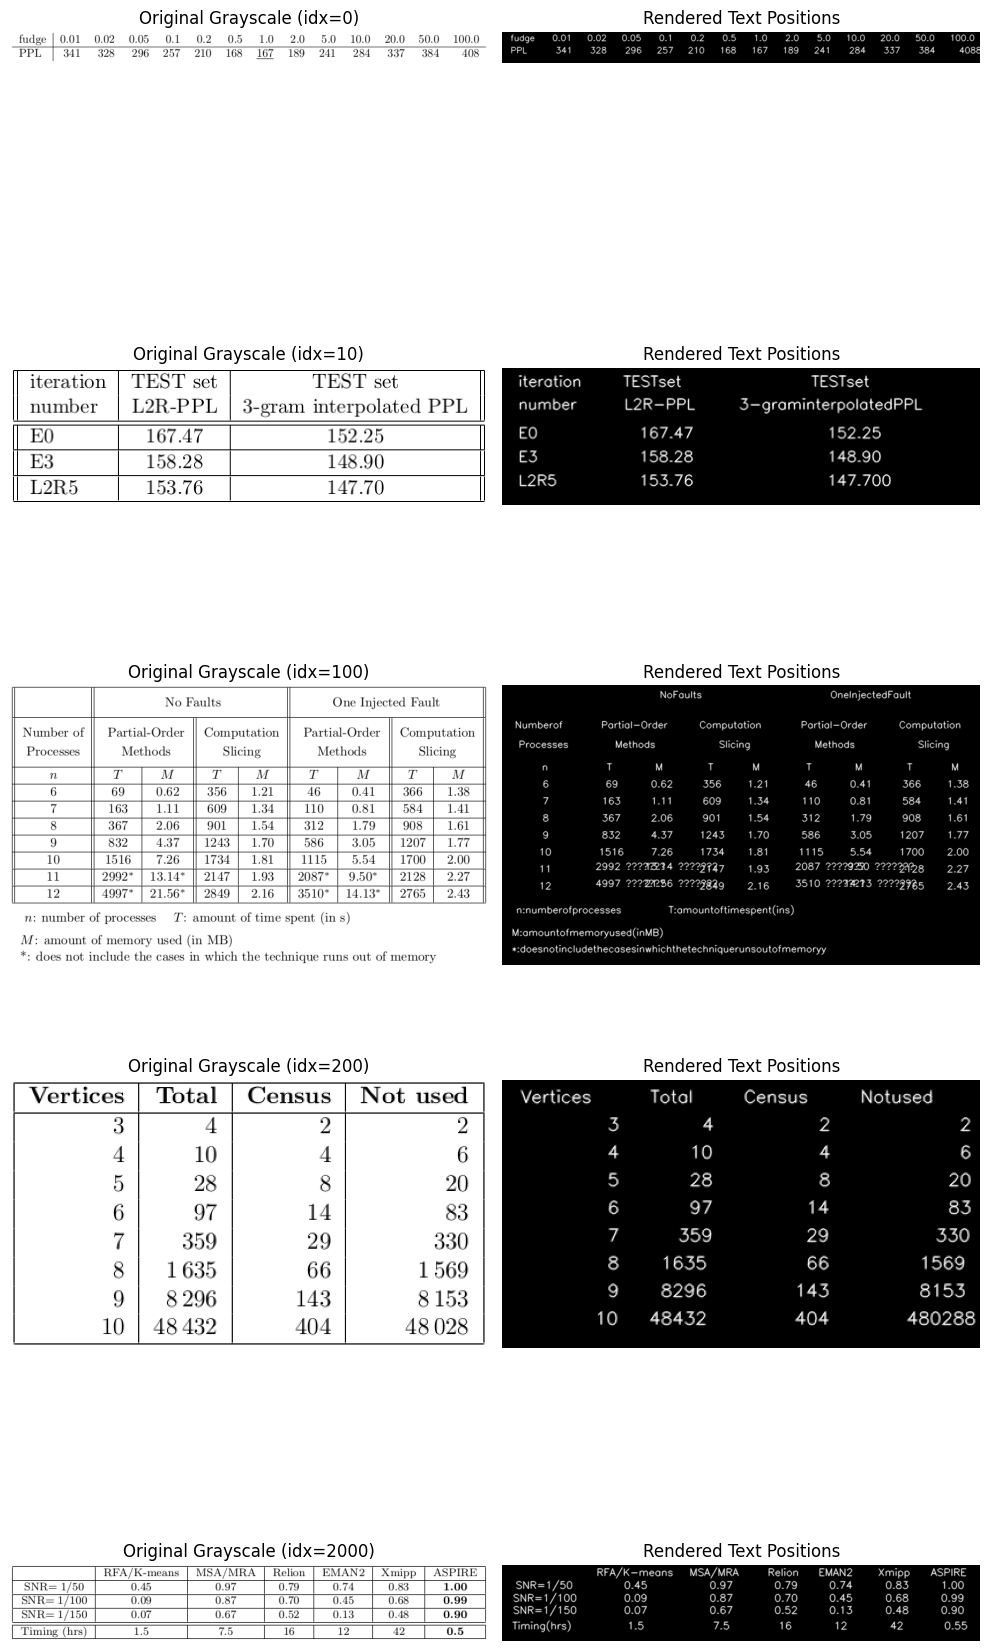

In [190]:
rindex = [0, 10, 100, 200, 2000]
plot_image_vs_render(rindex, tdataset)

In [195]:
i = rindex[2]
texts = get_val_from_json(tdataset[i]['chunks'], 'chunks', 'text')
for t in texts:
    print(t)

NoFaults
OneInjectedFault
Numberof
Partial-Order
Computation
Partial-Order
Computation
Processes
Methods
Slicing
Methods
Slicing
n
T
M
T
M
T
M
T
M
6
69
0.62
356
1.21
46
0.41
366
1.38
7
163
1.11
609
1.34
110
0.81
584
1.41
8
367
2.06
901
1.54
312
1.79
908
1.61
9
832
4.37
1243
1.70
586
3.05
1207
1.77
10
1516
7.26
1734
1.81
1115
5.54
1700
2.00
11
2992 âˆ—
13.14 âˆ—
2147
1.93
2087 âˆ—
9.50 âˆ—
2128
2.27
12
4997 âˆ—
21.56 âˆ—
2849
2.16
3510 âˆ—
14.13 âˆ—
2765
2.43
n:numberofprocesses
T:amountoftimespent(ins)
M:amountofmemoryused(inMB)
*:doesnotincludethecasesinwhichthetechniquerunsoutofmemoryy


This paper came out in 2021, pretty old for advancing topics like. Because of that they used old PDF extrating tools which arent as good as the current PDF extrating tools. 

Need to use the current tools to extract accurate outputs